# Hybrid Network (1D conv + LSTM) Training

In [1]:
# system
import os
import pickle
import gzip

# data manipulation
import pandas as pd
import numpy as np

# deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# get real dataset
with gzip.open('../../result/one_hot_encoding/gene_id_label_ohe.pkl.gz', 'rb') as f:
    data = pickle.load(f)

X = np.stack(data['upstream_region_encoded'].values)
Y = data['DE'].values
print(X.shape)
print(Y.shape)

X_train, X_dev, Y_train, Y_dev = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=123)
print(X_train.shape)
print(X_dev.shape)
print(Y_train.shape)
print(Y_dev.shape)

(55223, 2000, 4)
(55223,)
(44178, 2000, 4)
(11045, 2000, 4)
(44178,)
(11045,)


In [3]:
# data preprocess
X_train = np.expand_dims(X_train, axis=-1)
X_dev = np.expand_dims(X_dev, axis=-1) 

### Hyperparameters:

In [11]:
BATCH_SIZE = 256
EPOCH_SIZE = 20
LEARNING_RATE = 1e-3

In [12]:
p_n_ratio = np.sum(Y_train)/(Y_train.shape[0]-np.sum(Y_train))

In [13]:
train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(Y_train))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataset = TensorDataset(torch.FloatTensor(X_dev), torch.FloatTensor(Y_dev))
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [14]:
class DNAHybrid(nn.Module):
    def __init__(self):
        super(DNAHybrid, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv1d(4, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.MaxPool1d(2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.MaxPool1d(2)
        )
        
        self.lstm = nn.LSTM(
            input_size=128,
            hidden_size=64,
            num_layers=2,
            batch_first=True,
            dropout=0.3,
            bidirectional=True
        )
        
        self.fc = nn.Sequential(
            nn.Linear(128, 64), 
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            nn.Linear(64, 2)
        )
        
    def forward(self, x):
        x = x.permute(0, 2, 1) 
        
        # Rest remains the same
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.permute(0, 2, 1)
        x, _ = self.lstm(x)
        x = torch.mean(x, dim=1)
        x = self.fc(x)
        return x

def train_and_evaluate(model, train_loader, val_loader, num_epochs=20, p_n_ratio=1):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    model = model.to(device)
    pos_weight = 1/p_n_ratio if p_n_ratio > 0 else 1
    class_weights = torch.tensor([1., pos_weight], device=device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=3, verbose=True
    )
    
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).long()
            
            inputs = inputs.squeeze(-1).squeeze(-1)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            train_loss += loss.item()
            predicted = outputs.argmax(dim=1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        epoch_train_loss = train_loss / len(train_loader)
        epoch_train_acc = 100 * train_correct / train_total
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        all_labels = []
        all_predictions = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device).long()
                
                inputs = inputs.squeeze(-1).squeeze(-1)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                predicted = outputs.argmax(dim=1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
                # Collect predictions and true labels
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
        
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = 100 * val_correct / val_total
        
        scheduler.step(epoch_val_acc)
        
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)
        
        conf_matrix = confusion_matrix(all_labels, all_predictions, labels=[0, 1])
        tn, fp, fn, tp = conf_matrix.ravel()
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%')
        print(f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%, True Positives (TP): {tp}')
        print('-' * 50)
    
    # Plot results
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return history

Using device: cuda
Epoch 1/20:
Train Loss: 0.6907, Train Acc: 65.29%
Val Loss: 0.6784, Val Acc: 46.91%, True Positives (TP): 535
--------------------------------------------------
Epoch 2/20:
Train Loss: 0.6807, Train Acc: 66.16%
Val Loss: 0.6692, Val Acc: 61.42%, True Positives (TP): 425
--------------------------------------------------
Epoch 3/20:
Train Loss: 0.6778, Train Acc: 65.93%
Val Loss: 0.6667, Val Acc: 71.13%, True Positives (TP): 352
--------------------------------------------------
Epoch 4/20:
Train Loss: 0.6767, Train Acc: 66.62%
Val Loss: 0.6921, Val Acc: 43.42%, True Positives (TP): 561
--------------------------------------------------
Epoch 5/20:
Train Loss: 0.6739, Train Acc: 67.46%
Val Loss: 0.6766, Val Acc: 85.60%, True Positives (TP): 181
--------------------------------------------------
Epoch 6/20:
Train Loss: 0.6732, Train Acc: 66.50%
Val Loss: 0.7073, Val Acc: 31.87%, True Positives (TP): 647
--------------------------------------------------
Epoch 7/20:
Tra

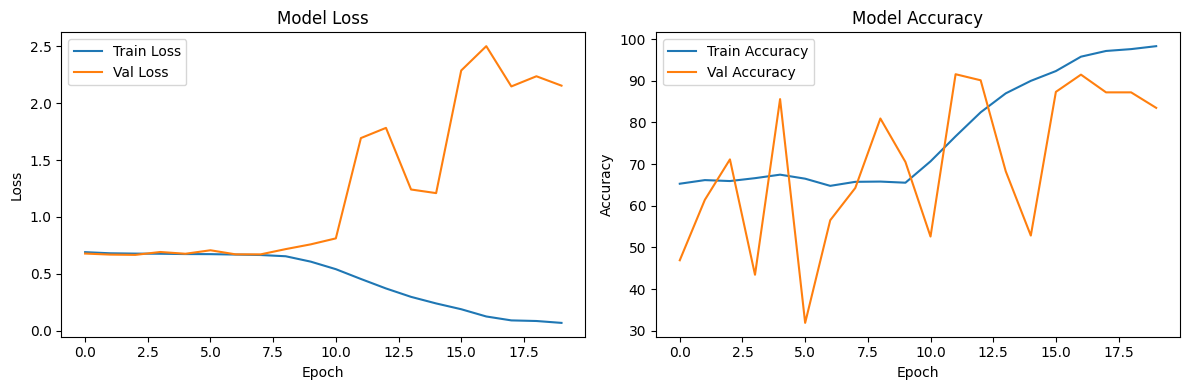

In [16]:
model = DNAHybrid()
history = train_and_evaluate(model, train_loader, val_loader, num_epochs=EPOCH_SIZE, p_n_ratio=torch.tensor(p_n_ratio).float())

In [18]:
# further analyasis

device = 'cuda'
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).long()

        inputs = inputs.squeeze(-1).squeeze(-1)
        outputs = model(inputs)
        predicted = outputs.argmax(dim=1)

        # Collect predictions and true labels
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

conf_matrix = confusion_matrix(all_labels, all_predictions, labels=[0, 1])
tn, fp, fn, tp = conf_matrix.ravel()

print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")

accuracy = (tp + tn) / (tp + fp + fn + tn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1_score:.2f}")


True Positives (TP): 116
False Positives (FP): 1154
True Negatives (TN): 9107
False Negatives (FN): 668
Accuracy: 83.50%
Precision: 0.09
Recall: 0.15
F1-Score: 0.11
